In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, TimeDistributed
from keras import optimizers

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
raw_data = np.loadtxt(open("EEG.csv", "rb"), delimiter=",", skiprows=0)
X_raw = raw_data[:,:-1]

# Data cleaning on X
upper_threshold = 4800
lower_threshold = 3800
too_big = X_raw>upper_threshold
too_small = X_raw<lower_threshold
X_cleaned = np.copy(X_raw)
X_cleaned[too_big] = upper_threshold
X_cleaned[too_small] = lower_threshold

X_toPCA = (X_cleaned - np.mean(X_cleaned)) / np.std(X_cleaned)
y = raw_data[:,-1]

In [3]:
pca = PCA(n_components=3)
X = pca.fit_transform(X_toPCA)

In [4]:
np.sum(pca.explained_variance_ratio_[:3])

0.81833831968396087

In [5]:
num_train = 7000
num_val = 7000
X_train = X[:num_train,:]
y_train = y[:num_train]
X_val = X[num_train:num_train+num_val,:]
y_val = y[num_train:num_train+num_val]
X_test = X[num_train+num_val:,:]
y_test = y[num_train+num_val:]

In [6]:
batch_size = 70
train_batch_length = int(num_train/batch_size)
X_train_batch = np.zeros((batch_size,train_batch_length,X.shape[-1]))
y_train_batch = np.zeros((batch_size,train_batch_length))
for i in range(train_batch_length):
    X_train_batch[:,i,:] = X_train[i*batch_size:(i+1)*batch_size,:]
    y_train_batch[:,i] = y_train[i*batch_size:(i+1)*batch_size]

val_batch_length = int(num_val/batch_size)
X_val_batch = np.zeros((batch_size,val_batch_length,X.shape[-1]))
y_val_batch = np.zeros((batch_size,val_batch_length))
for i in range(val_batch_length):
    X_val_batch[:,i,:] = X_val[i*batch_size:(i+1)*batch_size,:]
    y_val_batch[:,i] = y_val[i*batch_size:(i+1)*batch_size]
y_train_batch = y_train_batch.reshape((y_train_batch.shape[0],y_train_batch.shape[1],1))
y_val_batch = y_val_batch.reshape((y_val_batch.shape[0],y_val_batch.shape[1],1))

In [7]:
model = Sequential()
model.add(GRU(256,return_sequences=True, stateful = True,activation = 'tanh',batch_input_shape=X_train_batch.shape))
model.add(Dropout(0.5))
model.add(GRU(128,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
model.add(GRU(32,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
#model.add(GRU(32,return_sequences=True, stateful = True,activation = 'tanh'))
#model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
adam = optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer = adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train_batch, y_train_batch,validation_data = (X_val_batch,y_val_batch), epochs=40, batch_size=batch_size)

Train on 70 samples, validate on 70 samples
Epoch 1/40
70/70 [==============================] - 4s - loss: 0.6846 - acc: 0.6811 - val_loss: 0.6825 - val_acc: 0.6323
Epoch 2/40
70/70 [==============================] - 2s - loss: 0.6636 - acc: 0.7881 - val_loss: 0.6736 - val_acc: 0.6479
Epoch 3/40
70/70 [==============================] - 2s - loss: 0.6411 - acc: 0.8094 - val_loss: 0.6628 - val_acc: 0.6370
Epoch 4/40
70/70 [==============================] - 2s - loss: 0.6153 - acc: 0.8223 - val_loss: 0.6500 - val_acc: 0.6226
Epoch 5/40
70/70 [==============================] - 2s - loss: 0.5850 - acc: 0.8284 - val_loss: 0.6387 - val_acc: 0.6169
Epoch 6/40
70/70 [==============================] - 2s - loss: 0.5535 - acc: 0.8224 - val_loss: 0.6356 - val_acc: 0.6206
Epoch 7/40
70/70 [==============================] - 2s - loss: 0.5193 - acc: 0.8107 - val_loss: 0.6431 - val_acc: 0.6389
Epoch 8/40
70/70 [==============================] - 2s - loss: 0.4921 - acc: 0.7933 - val_loss: 0.6466 - val_

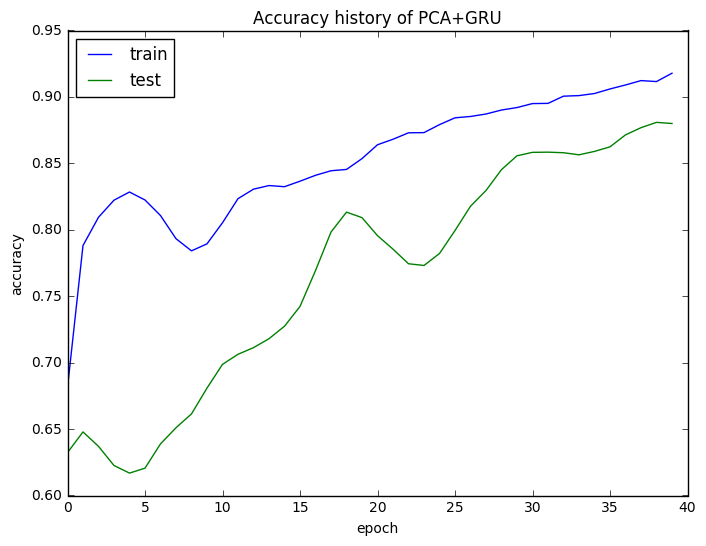

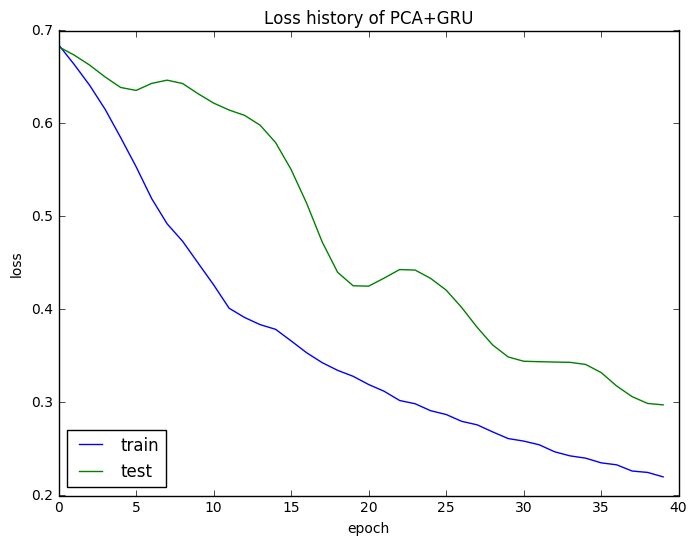

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy history of PCA+GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss history of PCA+GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [35]:
predicted = model.predict(X_val_batch[:35,:,:],batch_size=35)

ValueError: Cannot feed value of shape (35, 100, 3) for Tensor 'gru_1_input:0', which has shape '(70, 100, 3)'

In [32]:
predicted_state = predicted>0.5

In [33]:
predicted_state.shape

(70, 100, 1)

In [34]:
np.mean(y_val_batch.astype(bool)==predicted_state)

0.78442857142857148